In [233]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.graphics.tsaplots as snt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math  

import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

# Loading Data

In [234]:

df = pd.read_csv('/content/dataset_final.csv', parse_dates=['date'], index_col=['date'])
df = df.drop('Unnamed: 0', axis=1)
df.head()

,btc_price,gold_price,oil_wti_price,sp500_close,btc_num_trans,btc_google_search,btc_dr,gold_dr,oil_dr,sp500_dr,BVOL,GVOL,OVOL,VIX
date,,,,,,,,,,,,,,
2015-01-15,211.91,1352.8,46.37,1992.67,102309.0,3,0.568670,0.021141,-0.044705,-0.009291,0.853974,0.344132,0.344950,22.39
2015-01-16,199.46,1364.9,48.49,2019.42,104699.0,3,-0.060548,0.008905,0.044705,0.013335,0.857286,0.348453,0.346061,20.95
2015-01-20,208.00,1377.4,46.79,2022.55,98485.0,3,0.041924,0.009116,-0.035688,0.001549,0.857176,0.348518,0.346647,19.89
2015-01-21,225.51,1378.4,47.85,2032.12,98485.0,3,0.080826,0.000726,0.022402,0.004720,0.893605,0.350149,0.347336,18.85
2015-01-22,226.32,1390.2,45.93,2063.15,93698.0,3,0.003585,0.008524,-0.040953,0.015154,0.904949,0.351242,0.343230,16.40


In [235]:
df = df.loc['2016-01-01':]

In [236]:
# Select features (columns) to be involved intro training and predictions
cols = list(df)[0:14]
cols

# Extract dates (will be used in visualization)
datelist_train = list(df.index)
datelist_train

print('Training set shape == {}'.format(df.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1078, 14)
All timestamps == 1078
Featured selected: ['btc_price', 'gold_price', 'oil_wti_price', 'sp500_close', 'btc_num_trans', 'btc_google_search', 'btc_dr', 'gold_dr', 'oil_dr', 'sp500_dr', 'BVOL', 'GVOL', 'OVOL', 'VIX']


# Data pre-processing


In [237]:
df = df[cols].astype(str)
for i in cols:
    for j in range(0, len(df)):
        df[i][j] = df[i][j].replace(',', '')

df = df.astype(float)

# Using multiple features (predictors)
training_set = df[cols].values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1078, 14).


array([[4.33420000e+02, 1.12530000e+03, 3.68100000e+01, ...,
        1.81062055e-01, 4.09702048e-01, 2.07000000e+01],
       [4.32670000e+02, 1.12820000e+03, 3.59700000e+01, ...,
        1.83742049e-01, 4.35934330e-01, 1.93400000e+01],
       [4.32440000e+02, 1.14170000e+03, 3.39700000e+01, ...,
        1.86100796e-01, 4.13183108e-01, 2.05900000e+01],
       ...,
       [7.48883000e+03, 1.74540000e+03, 1.50600000e+01, ...,
        3.62172970e-01, 1.67877017e+00, 4.13800000e+01],
       [7.51464000e+03, 1.73560000e+03, 1.59900000e+01, ...,
        3.51590076e-01, 1.69290154e+00, 3.59300000e+01],
       [7.78977000e+03, 1.72380000e+03, 1.21700000e+01, ...,
        3.24403678e-01, 1.67803203e+00, 3.32900000e+01]])

In [238]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler(feature_range=(0, 1))
sc_predict.fit_transform(training_set[:, 0:1])

array([[0.0035572 ],
       [0.00351703],
       [0.00350471],
       ...,
       [0.38141763],
       [0.38279991],
       [0.39753481]])

In [239]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 5     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1014, 5, 13).
y_train shape == (1014, 1).


# Create a model

In [240]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [241]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df.shape[1]-1)))
# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [242]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=False, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
2/4 [==============>...............] - ETA: 0s - loss: 0.0746WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0274s vs `on_train_batch_end` time: 0.1655s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.07285, saving model to weights.h5
4/4 [==============================] - 1s 229ms/step - loss: 0.0637 - val_loss: 0.0728
Epoch 2/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0206
Epoch 00002: val_loss improved from 0.07285 to 0.00936, saving model to weights.h5
4/4 [==============================] - 0s 16ms/step - loss: 0.0324 - val_loss: 0.0094
Epoch 3/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0920
Epoch 00003: val_loss did not improve from 0.00936
4/4 [==============================] - 0s 14ms/step - loss: 0.0531 - val_loss: 0.0182
Epoch 4/30
1/4 [======>.......................] - ETA: 0s - loss: 0.0208
Epoch 00004: val_loss did not improve from 0.00936
4/4 [=====

# Make future predictions

In [243]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [244]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [245]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['btc_price']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['btc_price']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,btc_price
2016-04-13,-1222.361328
2016-04-14,-1301.678467
2016-04-15,-1356.314819


# Visualize the Predictions

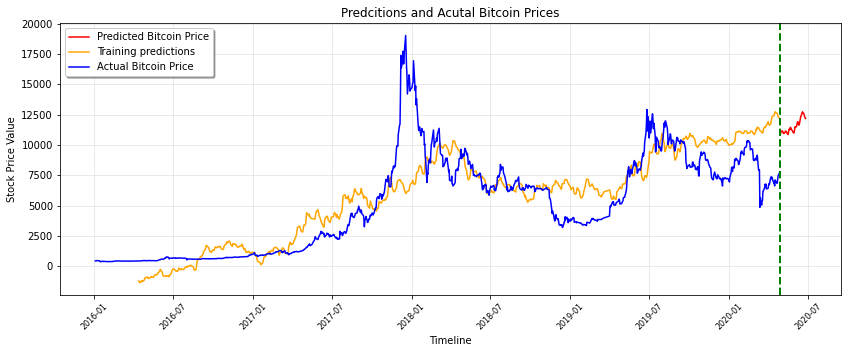

In [246]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2015-12-28'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['btc_price'], color='r', label='Predicted Bitcoin Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['btc_price'], color='orange', label='Training predictions')
plt.plot(df.loc[START_DATE_FOR_PLOTTING:].index, df.loc[START_DATE_FOR_PLOTTING:]['btc_price'], color='b', label='Actual Bitcoin Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Bitcoin Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [251]:
z = df.iloc[-60:,0]
q = pd.concat([PREDICTION_TRAIN.loc['2020-01-31':],z],axis =1)
q.columns =  ['prediction', 'btc_price']
q.head()

,prediction,btc_price
2020-01-31,10960.052734,9334.98
2020-02-03,10951.107422,9280.49
2020-02-04,10968.074219,9164.33
2020-02-05,11082.427734,9613.82
2020-02-06,11143.142578,9763.01


# Error 

In [252]:
#Forecast bias
forecast_errors = [q['btc_price'][i]- q['prediction'][i] for i in range(len(q['btc_price']))]
bias = sum(forecast_errors) * 1.0/len(q['btc_price'])
print('Bias: %f' % bias)
print('Mean absolute error:', mean_absolute_error(q['btc_price'].values, q['prediction'].values))
print('Mean squared error:', mean_squared_error(q['btc_price'].values, q['prediction'].values))
print('Root mean squared error:', math.sqrt(mean_squared_error(q['btc_price'].values, q['prediction'].values)))

Bias: -3632.123673
Mean absolute error: 3632.123672526042
Mean squared error: 16571703.982467346
Root mean squared error: 4070.835784266831
